# Deep learning on time series data guide

# Table Of Contents
<ul>
    <li><a href="#Introduction-" data-toc-modified-id="Introduction--1">Introduction</a></li>
    <li><a href="#Data-Preparation-" data-toc-modified-id="Data-Preparation--2">Data Preparation</a>
        <ul>
            <li><a href="#Prepare_tabulardata-" data-toc-modified-id="Prepare_tabulardata--2">Prepare_tabulardata</a></li>
            <li><a href="#Visualization-" data-toc-modified-id="visualization--3">Visualization</a></li>
        </ul>
    </li>
    <li><a href="#Model-Training-" data-toc-modified-id="Model-Training--4">Model Training</a>
        <ul>
            <li><a href='#Model Architecture'>Model Architecture</a></li>
            <li><a href='#Sequence_Length'>Sequence Length</a></li>
        </ul>        
    </li>
    <li><a href="#Model-Validation-Metrics-" data-toc-modified-id="Model-Validation-Metrics--5">Model Validation Metrics</a></li>
    <li><a href="#Time-Series-Forecasting-" data-toc-modified-id="Time-Series-Forecasting--4">Time Series Forecasting</a></li>
</ul>

## Introduction <a class="anchor" id="1"></a>

The `arcgis.learn` module includes [TimeSeriesModel](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#timeseriesmodel) class to train deep learning models on timeseries tabular data. Timeseries tabular data can be in the form of a [feature layer](https://developers.arcgis.com/python/guide/working-with-feature-layers-and-features/), [spatially enabled dataframe](https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/) or a simple dataframe.

`TimeSeriesModel` has support for both univariate as well as multivariate time series. 

In the case of multivariate time series,, explanatory variables can take the form of fields in the attribute table of the feature layer, raster datasets, or distance features used to calculate proximity values for use as additional variables. In the case of univariate time series,, the dependent variable can belong to the feature layer or raster. `TimeSeriesModel` can be used to predict a final raster from a series of rasters representing change over a period of time.

In addition to validation of model performance based on the training data, predictions can also produce either features or a prediction raster.

## Data Preparation <a class="anchor" id="1"></a>

Data preparation can be a time consuming process that typically involves splitting the data into training and validation sets, applying various data augmentation techniques, creating the necessary data structures for loading data into the model, memory management by using the appropriately sized mini-batches of data, and so on.

You can use the `prepare_tabulardata()` method to create a tabular data object, that formats the sequential data so that it can be fed into the `TimeSeriesModel` model. It allows you to use attribute data from feature layers and DataFrames. Additionally, you can use explanatory rasters. The raster can be an imagery layer that can be accessed through ArcGIS Enterprise or through local raster files accessed using the `Raster` class from the `arcgis.raster` module. This method performs normalization of the datasets, imputation, and splits it into training and validation datasets, before then feeding the datasets into the model.

### Prepare_tabulardata <a class="anchor" id="3"></a>

In cases of a univariate timeseries, a single variable will be used to forecast for the next given time period, which means the same variable will be used to predict future terms of that variable, and thus has no other explanatory variables.

In cases of a multivariate time series model, there will be a list of explanatory variables created as follows:  making a list of the explanatory variables
			
				X = ["Field_1", ("Field_2", True),......."Field_n"]

Here, Field_2 is treated as categorical, while the others are treated as continuous variables.

Once the variables are identified, the preprocessing of the data is carried out by the `prepare_tabulardata` method. This function will take either a non spatial dataframe, a feature layer, or a spatial dataframe containing the dataset as input and will return a tabular data object that can be fed into the model for training. The function also works on a combination of feature layers or spatial dataframes with rasters in which the values of the raster corresponding to the features are selected for preparing the final data.  The function can also be used with a series of rasters where the dependent variable identifies the target raster.

Once the explanatory variables and explanatory rasters are defined, we can prepare our tabular data object by using the `prepare_tabulardata()` function. The following are some of the key arguments for this function:

`input_features`: Takes data in the form of a feature layer, spatially enabled DataFrame, or non spatial dataframe. Feature layers can be of point or polygon geometry.

`variable_predict`: Field name from the `input_features` layer or `explanatory_rasters`. It automatically deduces fields as continuous or categorical by using a simple logic. If the field type is float and has more than 20 unique values, the field is considered continuous. Otherwise, the field will be considered categorical.

`date_field`: Field name from the `input_features` layer. If specified, the field will be split into year, month, week, day, dayofweek, dayofyear, is_month_end, is_month_start, is_quarter_end, is_quarter_start, is_year_end, is_year_start, hour, minute, second, elapsed. If specified here, there is no need to specify as part of `explanatory_variables`.

`explanatory_variables`: List of the field names containing the explanatory variables from the `input_layer`, where tuples of size 2 have to be passed for categorical variables, as discussed above. For univariate cases, these are not required.

`explanatory_rasters`: List of the Raster objects containing the explanatory variables, where tuples of size 2 have to be passed for categorical variables, as discussed above.

`distance_features`: Distance features are used to automatically create explanatory variables by calculating a distance from the provided features to the input_features. Distances will be calculated from each of the input explanatory distance features to the nearest input training features. If the input `distance_features` are polygons or lines, the distance attributes are calculated as the distance between the closest segments of the pair of features. However, distances are calculated differently for polygons and lines. See how [proximity tools calculate distance](https://pro.arcgis.com/en/pro-app/tool-reference/analysis/how-near-analysis-works.htm) for details.

`index_field`: Name of the field that contains the indexes for the data. This is useful when visualizing the time series data. It is usually a timestamp or date time field.

Once the explanatory variables or the explanatory rasters list is ready, it can be used as input for the `prepare_tabulardata()` function. The function takes the feature layer or a spatial DataFrame containing the dataset, along with the y-variable defined as the `variable_predict`, and prepares it for fitting the `TimeSeriesModel` model as follows:

In [ ]:
data = prepare_tabulardata(input_features,
                            variable_predict, 
                            explanatory_variables=X,
                            explanatory_rasters=explanatory_rasters)

### Visualization <a class="anchor" id="4"></a>

Data visualization can provide useful information for timeseries modeling. For example, it can show if any data is missing, which could impact a model's efficacy.

It could also reveal the seasonality of the data to some extent. For instance, it could make the time of peaks and troughs more obvious, which can help in determining the lag/sequence length for data initialization, a very significant parameter for modeling timeseries data.

This visualization is done by `data.show_batch()`. All time series data must have a datetime column that `data.show_batch()` will use to plot time series data, with the time stamp in the x - axis and the variable in y axis.

In [ ]:
data.show_batch(graph=True)

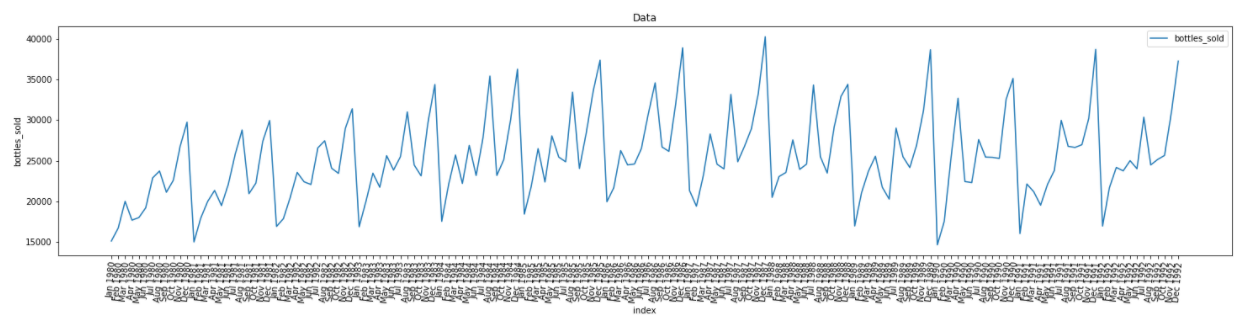

## Model Training <a class="anchor" id="5"></a>
This is the most significant step for fitting a timeseries model. Here along with the data, the backbone for training the model and the sequence length is passed as the parameters. 

The timeseries model is initialized as follows, after importing the model as shown here: 

In [ ]:
from arcgis.learn import TimeSeriesModel, prepare_tabulardata

In [ ]:
model = TimeSeriesModel(data, seq_len=n, model_arch='FCN')

### Model Architecture <a id='Model Architecture'></a>

In the above model initialization, the data, sequence length, and the model architecture of FCN are selected. Here, FCN is the fully connected network model. Other available backbones includes deep learning CNN based InceptionTime, ResCNN, and Resnet.

### Sequence Length <a id='Sequence_Length'></a>

Out of the above mentioned parameters, the seq_len (sequence length) is a critical parameter and typically requires research to determine.

It has to be selected carefully for fitting a timeseries model. The sequence length here would usually be the seasonality of the data, and is used as the length of past dataset that will be used to forecast the subsequent sequence.

Usually it is 1 if its yearly data, 12 for monthly data,  52 if it is weekly data, and 365 if it is daily data. These assumption would hold true for data which has yearly periodicity, or where similar pattern repeats in a yearly fashion like for example the various seasons in a year. However in some rare cases data also can have multiple periodicity in various combination of monthly, weekly, daily, and quarterly, which are usually hard to model, hence would need some consideration and research before finalizing sequence length for such data.
    
Data visualization can provide useful information for timeseries modeling, for example it  can show if any data is missing, which might impact model efficacy. It could also reveal the seasonality of the data to some extent, the time of peaks and troughs etc., where visual inspection of the graphs could help determine the lag/sequence length for data initialization.

Thus while experimenting with sequence length, use the seq_len parameter described in the visualization section to visualize the trend of data over the specified sequence length.

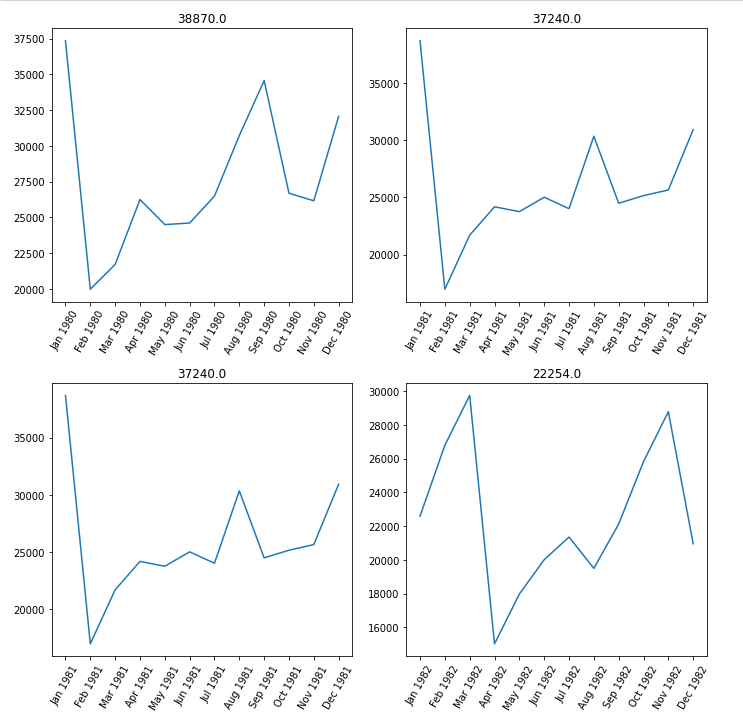

**Learning Rate Search** -
The initialized model will need a learning rate for training, and the `lr_find()` method can be used to search for an optimal learning rate as follows:

In [ ]:
model.lr_find()

The output from `lr_find()` can be used while fitting the model, however, a different learning rate, determined by interpreting the graph, can be used for model training. You can also skip using `lr_find()` and instead directly jump to `fit()` by specifying the number of epochs. In this case, the API will internally call the `lr_find()` and use the resulting suggested value.

For example, in the line below, the timeseries model is trained for 50 epochs, while automatically estimating the learning rate.

In [ ]:
model.fit(50)

## Model Validation Metrics <a class="anchor" id="6"></a>

Once the model is trained, we need to visualize the results and measure the performance.

- `show_results()` - The training results can be printed using `show_results()` method to assess the quality of the trained model and compute the model's metrics. For timeseries models the `show_results(`) method will typically print two adjacent graphs with the ground truth values plotted in the left hand graph and the predictions in the right hand side. Here the  predictions would be the values predicted by the model after being applied to the validation dataset. Comparing the predicted values with the actual target variable or groudn truth will give some indication of the performance of the trained model. Thus here ``model.show_results(rows=5)`` would return the comparison of five target vs prediction values as follows:

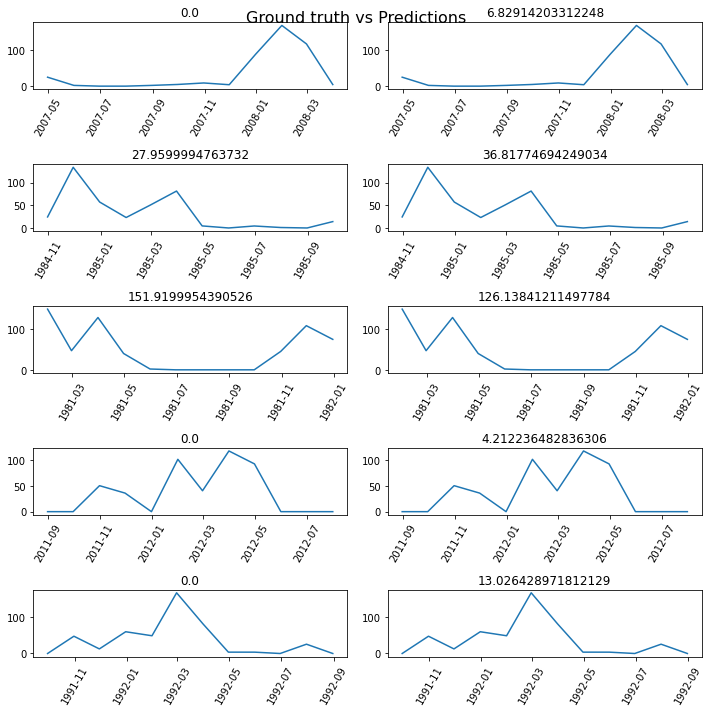

- `score()` - Subsequently, the model metrics of the trained model can be estimated using the `score()` function. This function currently returns the r-square/accuracy, which also reflects model performance.

## Time Series Forecasting <a class="anchor" id="7"></a>

The `TimeSeriesModel` class can be used to make predictions of a feature layer or dataframe, or to predict a raster.

When making predictions of a feature layer or a dataframe, the dependent variable is assumed to be present in the input feature or raster, with the `seq_len` number of values already present.  The `number_of_predictions` parameter controls the number of predictions to append to the existing sequence, however, if not specified, the model makes predictions equal to the number of null rows in the input feature. The index field is also populated if it is of type timestamp.

When making predictions of a raster, the function accepts only rasters. The values of all rasters for a given pixel are used to predict the value of that pixel in the output raster.